In [203]:
'''Modified from sklearn documentation: https://scikit-learn.org/stable/modules/compose.html
'''
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn import datasets
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.datasets import make_classification
from pcsp import PCSPipeline, ModuleSet, Module # must install pcsp first (pip install pcsp)
from pcsp.pipeline import build_graph
from sklearn.metrics import accuracy_score, balanced_accuracy_score, roc_auc_score,r2_score
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import sklearn
from functools import partial
import itertools
import networkx as nx
np.set_printoptions(threshold=5) # to limit printing

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# basic pipeline

/Users/abhineetagarwal/pcs-pipeline/pcsp/pipeline.py:117: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


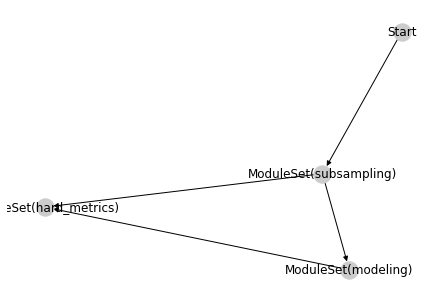

{(('data_0', 'subsampling_0', 'LR'),
  ('data_0', 'subsampling_0')): array([0, 0, 0, ..., 0, 0, 0]),
 (('data_0', 'subsampling_0', 'DT'),
  ('data_0', 'subsampling_0')): array([0, 0, 0, ..., 0, 0, 0]),
 (('data_0', 'subsampling_1', 'LR'),
  ('data_0', 'subsampling_0')): array([0, 0, 0, ..., 0, 0, 0]),
 (('data_0', 'subsampling_1', 'DT'),
  ('data_0', 'subsampling_0')): array([0, 0, 0, ..., 0, 0, 0]),
 (('data_0', 'subsampling_2', 'LR'),
  ('data_0', 'subsampling_0')): array([0, 0, 0, ..., 0, 0, 0]),
 (('data_0', 'subsampling_2', 'DT'),
  ('data_0', 'subsampling_0')): array([0, 0, 0, ..., 0, 0, 0]),
 (('data_0', 'subsampling_0', 'LR'),
  ('data_0', 'subsampling_1')): array([0, 0, 1, ..., 0, 0, 0]),
 (('data_0', 'subsampling_0', 'DT'),
  ('data_0', 'subsampling_1')): array([0, 0, 1, ..., 0, 0, 0]),
 (('data_0', 'subsampling_1', 'LR'),
  ('data_0', 'subsampling_1')): array([0, 0, 1, ..., 0, 0, 0]),
 (('data_0', 'subsampling_1', 'DT'),
  ('data_0', 'subsampling_1')): array([0, 0, 1, ..., 0

In [202]:
# subsample data
np.random.seed(13)
X, y = make_classification(n_samples=50, n_features=5)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
subsampling_funcs = [partial(resample,
                            n_samples=int(X_train.shape[0]*0.3),
                            random_state=i)
                     for i in range(3)]
subsampling_set = ModuleSet(name='subsampling',
                            modules=subsampling_funcs)

X_all, y_all = subsampling_set(X_train, y_train) # subsampling_set([X_train, X_train], [y_train, y_train]) # artificially make it seem like there are multiple dsets (data_0 and data_1)

# fit models
modeling_set = ModuleSet(name='modeling',
                         modules=[LogisticRegression(max_iter=1000, tol=0.1),
                                  DecisionTreeClassifier()],
                         module_keys=["LR", "DT"],output = {})

_ = modeling_set.fit(X_all, y_all)
#get predictions
X_all["test"] = X_test
y_all["test"] = y_test

preds_all = modeling_set.predict(X_all)
# get metrics
hard_metrics_set = ModuleSet(name='hard_metrics',
                             modules=[accuracy_score, balanced_accuracy_score],
                             module_keys=["Acc", "Bal_Acc"],output = {})

hard_metrics = hard_metrics_set.evaluate(y_all, preds_all)
#hard_metrics.__prev__[0]
#inspect the pipeline
#for k1, v1 in hard_metrics.output.items():
    #print(k1)
G = build_graph(hard_metrics, draw=True)
plt.show()
preds_all

# feature engineering pipeline
**this data set predicts boston house-preices dataset (regression)**

In [205]:
# get data as df
np.random.seed(13)
data = sklearn.datasets.load_boston()
df = pd.DataFrame.from_dict(data['data'])
df.columns = data['feature_names']
y = data['target']
X_train, X_test, y_train, y_test = train_test_split(df, y, random_state=42)


# feature extraction - extracts two different sets of features from the same data
def extract_feats(df: pd.DataFrame, feat_names=['CRIM', 'ZN', 'INDUS', 'CHAS']):
    '''extract specific columns from dataframe
    '''
    return df[feat_names]
feat_extraction_funcs = [partial(extract_feats, feat_names=['CRIM', 'ZN', 'INDUS', 'CHAS']),
                         partial(extract_feats, feat_names=['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE']),
                        ]
feat_extraction = ModuleSet(name='feat_extraction',
                            modules=feat_extraction_funcs,output = {})

X_feats_train = feat_extraction(X_train)
X_feats_test = feat_extraction(X_test)

#print(X_feats_train) 
#X_feats_train(),still weird that this is a list
#X_feats_train
# TODO: this is broken atm.. may want to preserve ModuleSet.modules in their original form of modules / functions
X_feats_test = feat_extraction(X_test) # still weird that this is a list


#fit models
y = {
     'data_0': y_train,
     'data_1': y_test
}

y_train_dict = {('data_0', 'feat_extraction_0'): y_train, ('data_0', 'feat_extraction_1'): y_train}
modeling_set = ModuleSet(name='modeling',
                         modules=[Ridge(max_iter=1000, tol=0.1),
                                  DecisionTreeRegressor()],
                         module_keys=["Ridge", "DT"],output = {})
# how can we properly pass a y here so that it will fit properly?
_ = modeling_set.fit(X_feats_train, y_train_dict)


#get predictions
preds_all = modeling_set.predict(X_feats_test)

y_test_dict = {('data_0', 'feat_extraction_0'): y_test, ('data_0', 'feat_extraction_1'): y_test}

#get metrics
hard_metrics_set = ModuleSet(name='hard_metrics',
                             modules=[r2_score],
                            module_keys=["r2"],output = {})
hard_metrics = hard_metrics_set.evaluate(y_test_dict, preds_all)


# inspect the pipeline
#for k in hard_metrics:
#     print(k, hard_metrics[k])
#G = build_graph(hard_metrics, draw=True)
#plt.show()
hard_metrics.output

{(('data_0', 'feat_extraction_0', 'Ridge'),
  ('data_0', 'feat_extraction_1'),
  'r2'): 0.5315623536522904,
 (('data_0', 'feat_extraction_0', 'DT'),
  ('data_0', 'feat_extraction_1'),
  'r2'): 0.6693138308148314,
 (('data_0', 'feat_extraction_1', 'Ridge'),
  ('data_0', 'feat_extraction_1'),
  'r2'): 0.5315623536522904,
 (('data_0', 'feat_extraction_1', 'DT'),
  ('data_0', 'feat_extraction_1'),
  'r2'): 0.6693138308148314,
 '__prev__': <pcsp.module_set.ModuleSet at 0x1472f6390>}

In [187]:
y_train_dict

{('data_0',
  'feat_extraction_0'): array([37.9, 15.6, 45.4, ..., 24.5, 13.4, 18.6]),
 ('data_0',
  'feat_extraction_1'): array([37.9, 15.6, 45.4, ..., 24.5, 13.4, 18.6])}

In [ ]:
preds_all

# tracking things w Pipeline (deprecated)

In [ ]:
p = PCSPipeline()

In [ ]:
p.steps = [subsampling_set, modeling_set, hard_metrics_set] # how to deal w/ hard metrics?

In [ ]:
# broken
# p.run(X_train, y_train)

In [ ]:
p.steps[2].modules

In [ ]:
# broken
#df = p.generate_names()
#df['hard_metrics'] = hard_metrics
#df